# Gap Tuning for the Robot Arm
This Jupyter Notebook plots the fidelity metrics for the SimpleMoves scenario and performs a change point analysis and linear regression on the input data to analyze the influence and statistical significance of the MAD, opening, and extending gap parameters on the fidelity metrics (% matched snapshots, Frèchet distance, Euclidean distance).

It takes the information stored in */resources/output/braccio/gap_tuning* from previously performed alignments and executes the corresponding computations.

In this case, to properly detect the change point, we ordered the algorithm to look for two changes. The second one is the one chosen for the analysis in the technical report.

## Imports and constants

In [1]:
import os

import matplotlib.pyplot as plt
import ruptures as rpt
import pandas as pd
from util import generate_sublist

from result_analysis import get_change_point
from result_analysis.gap_tunning import execute_regression

from IPython.display import Markdown, HTML

current_directory = os.path.abspath(os.path.join(os.getcwd(), '../../'))
output_directory = current_directory + '/resources/output/braccio/gap_tuning/original_results/'

files = ['simple_moves_dtsimple_moves_pt-s1.csv']

param_interest = 's1'

params = [f'mad_{param_interest}',
          'init_gap',
          'cont_gap',
          'percentage_matched_snapshots',
          'frechet_euclidean',
          'p2p_mean_euclidean_mean',
          'number_of_gaps',
          'mean_length_gaps_mean']

params_labels = [f'MAD degrees',
                 'Penalty Opening Gap',
                 'Penalty Extending Gap',
                 '%matched snapshots',
                 'Frèchet euclidean',
                 'Euclidean Avg',
                 'Number of gaps',
                 'Avg length of gaps']

ordering_params = [3, 6]
include_params = [[(0, 5)], [(0, 3), (6, 7)]]
filters = {'affine': ['init_gap', lambda x: x < 0.0],
           'simple' : ['init_gap', lambda x: x == 0.0]}
assert(len(ordering_params) == len(include_params))

## Change point analysis and linear regression

# Scenario simple moves dtsimple moves pt-s1


## Affine Gap


### Ordered by %matched snapshots


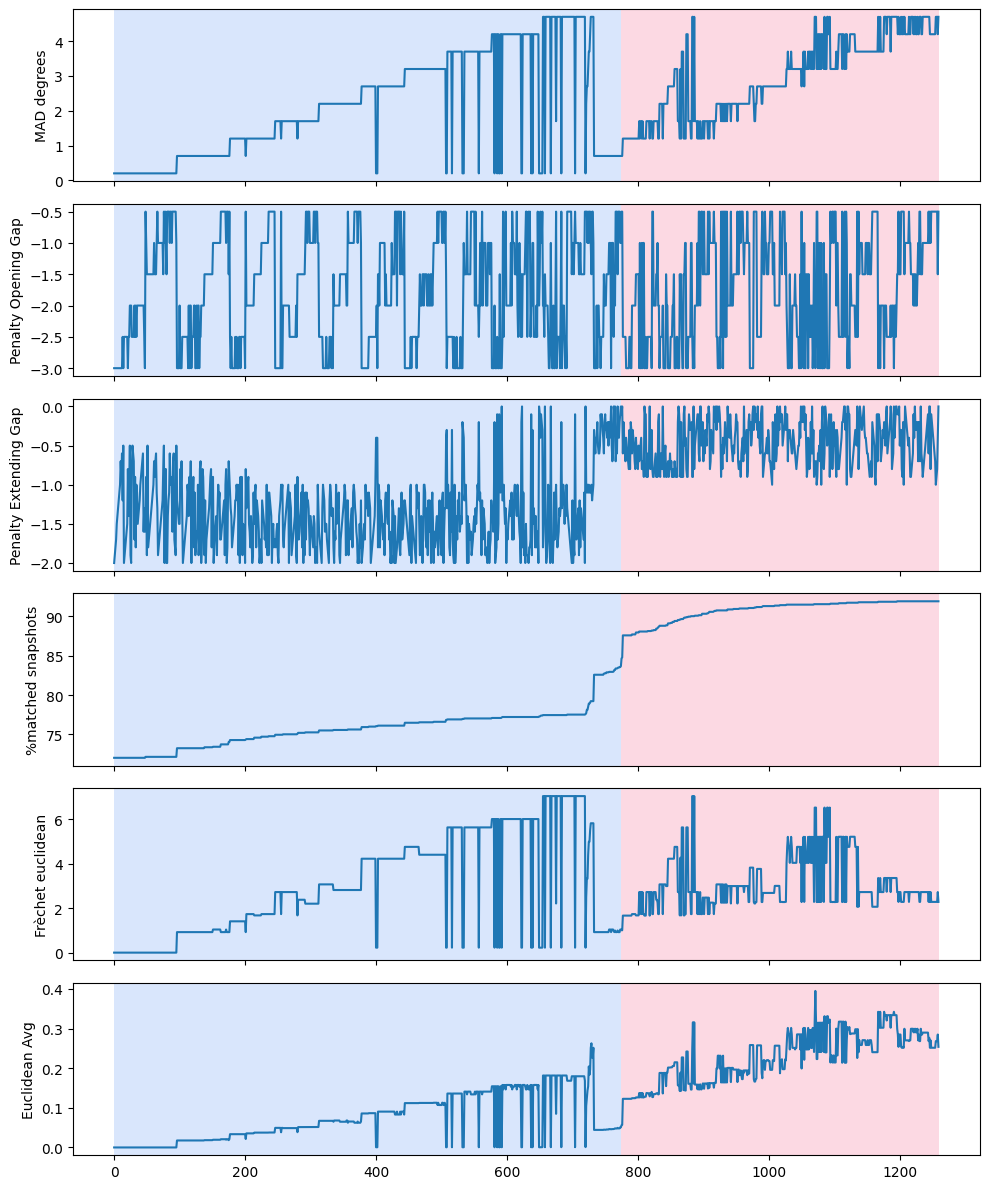

### Ordered by Number of gaps


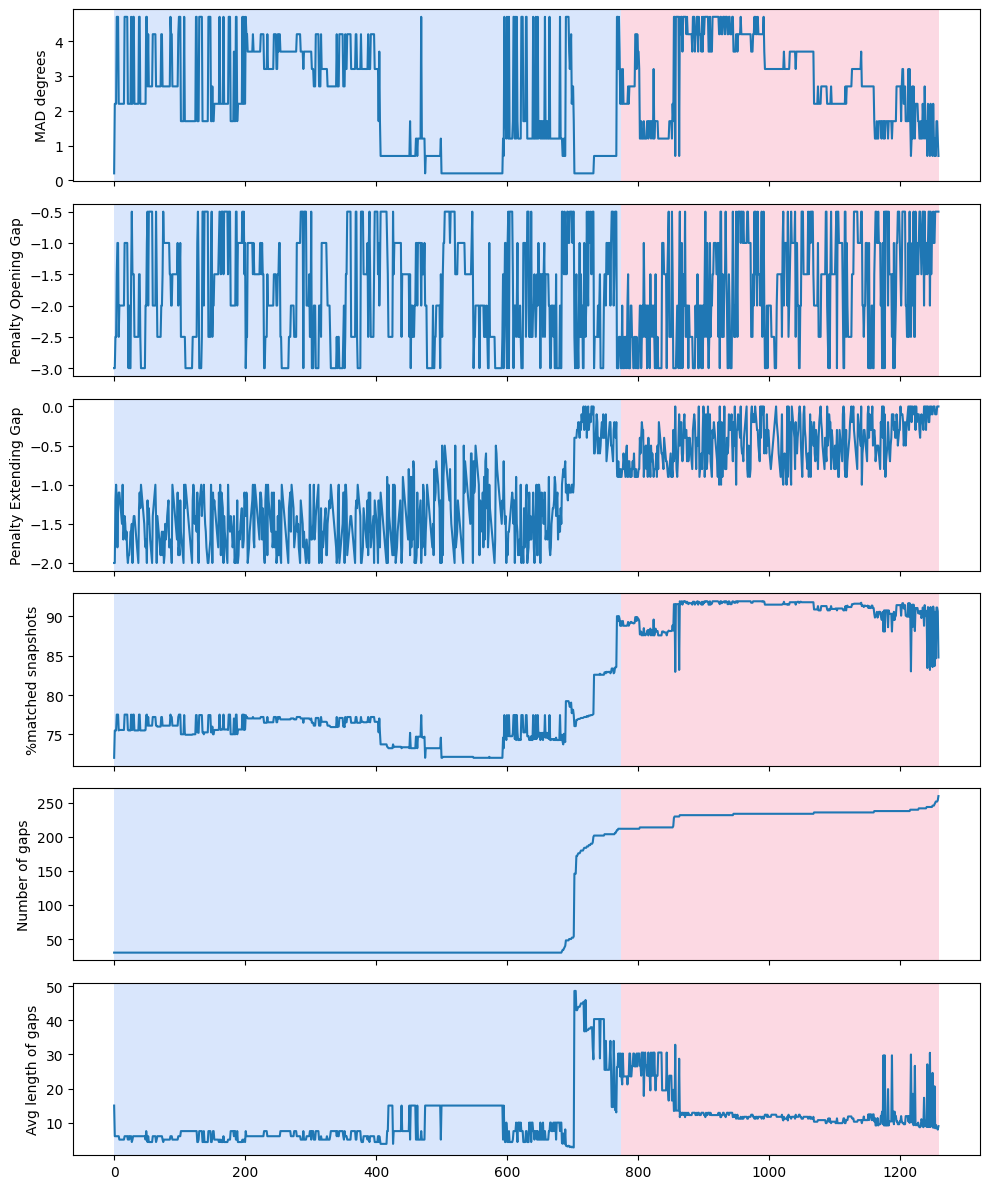

### Analysis all samples


### Analysis segment


## Simple Gap


### Ordered by %matched snapshots


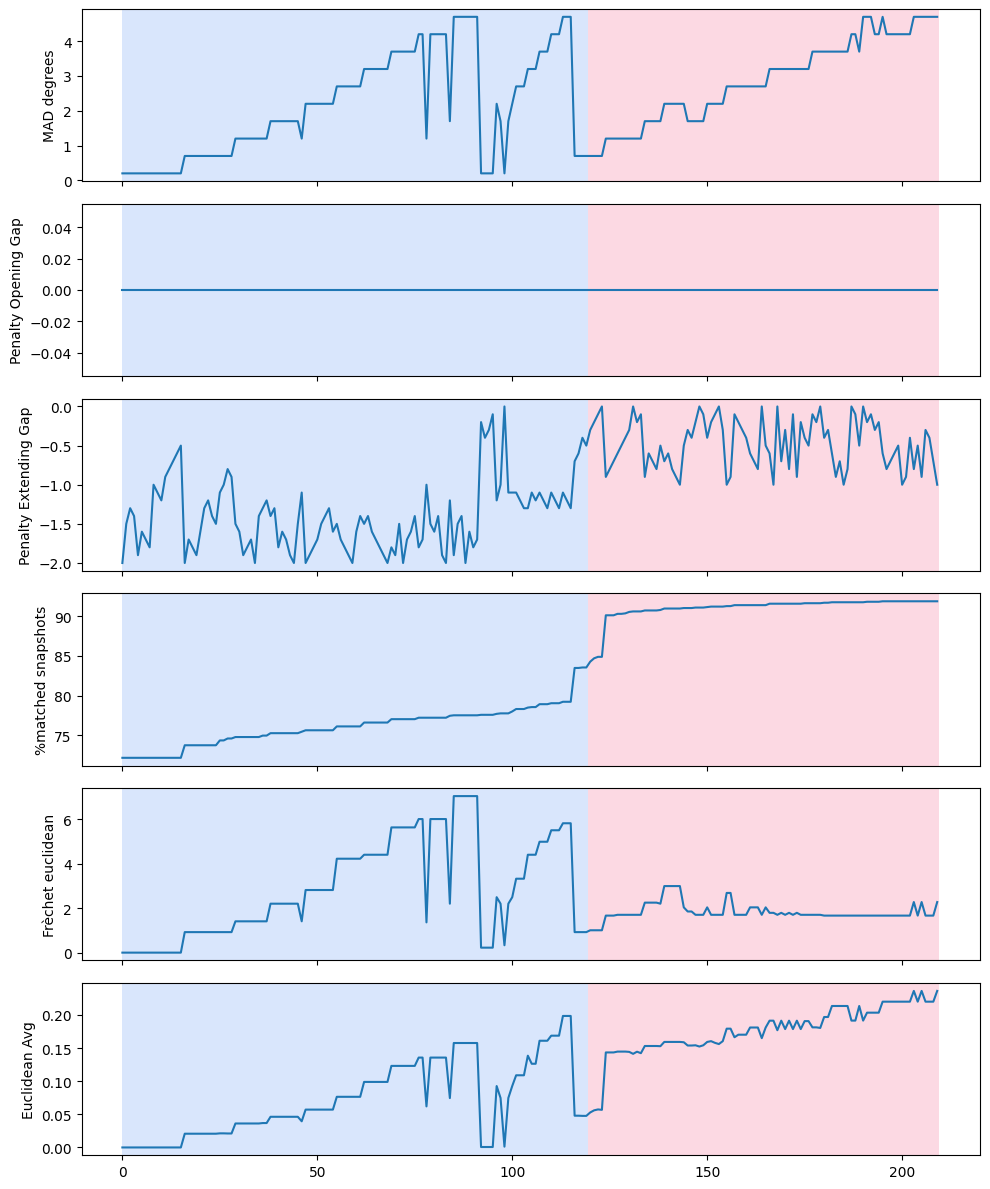

### Ordered by Number of gaps


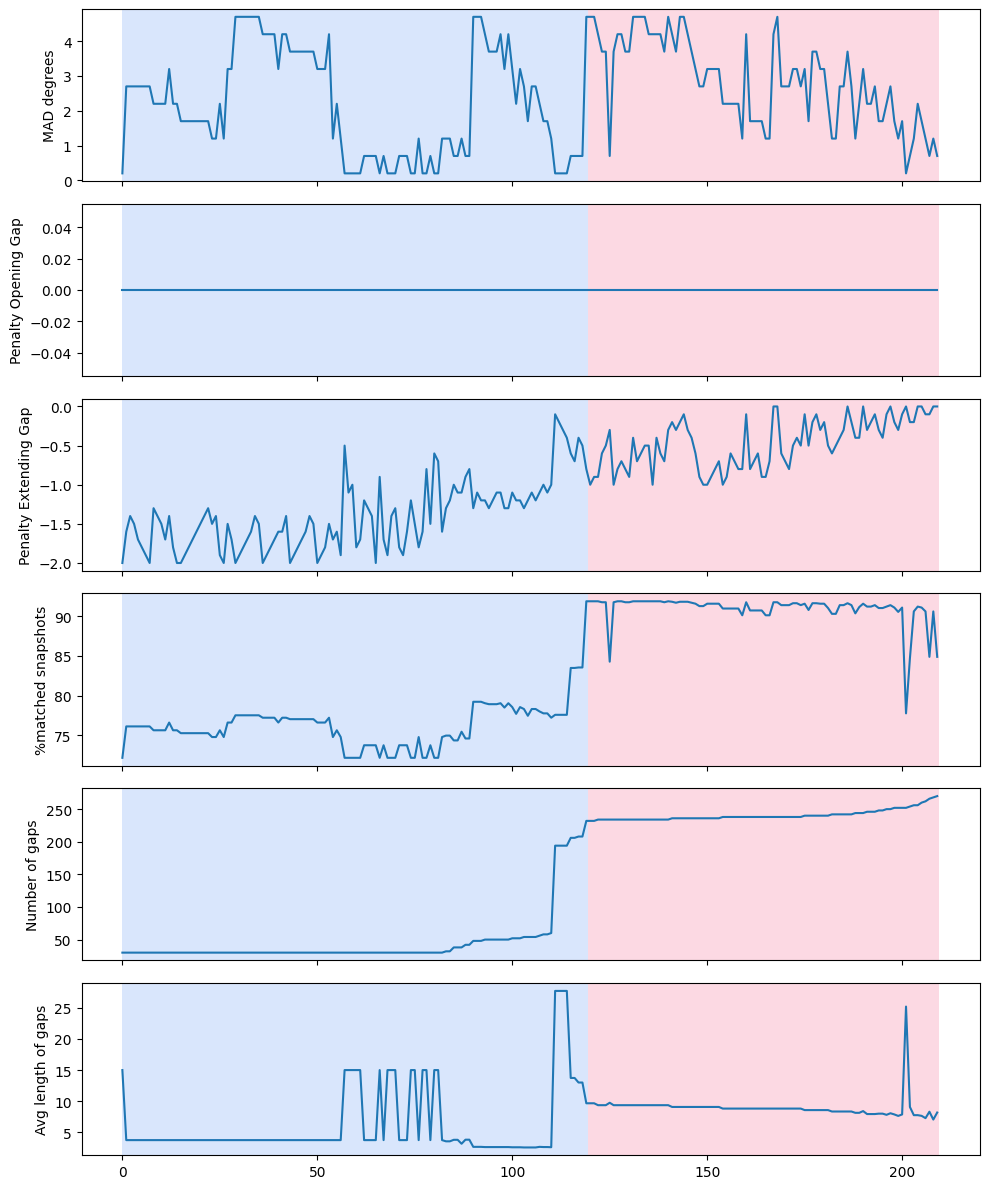

### Analysis all samples


### Analysis segment


In [2]:
for file in files:
    display(Markdown(f'# Scenario {file.replace("_", " ").replace(".csv", "")}\n'))
    df = pd.read_csv(f'{output_directory}{file}')
    for gap_type, values in filters.items():
        display(Markdown(f'## {gap_type.capitalize()} Gap\n'))
        # Filter the values to perform the analysis of the affine or the simple gap
        filtered_df = df[values[1](df[values[0]])]
        result_prev = None
        for index, ordering_param in enumerate(ordering_params):
            display(Markdown(f'### Ordered by {params_labels[ordering_param]}\n'))
            selected_params = generate_sublist(params, include_params[index])
            selected_label_params = generate_sublist(params_labels, include_params[index])

            # It performs the change point analysis: Given a segment model, it computes the best partition
            # In this case, we configured it to look for two changes and we keep this second change as change point for the analysis in the technical report.
            signals, result = get_change_point(filtered_df,
                                               [selected_params[0], params[ordering_param]],
                                               selected_params, number_of_changes=2)

            # To keep the change point of the first graphic in the gap analysis
            if not result_prev:
                result_prev = result
            _, axs = rpt.display(signals, result_prev[-2:])

            for i, label in enumerate(selected_label_params):
                axs[i].set_ylabel(label)

            plt.tight_layout()
            plt.show()

        display(Markdown(f'### Analysis all samples\n'))
        display(HTML(execute_regression(df, 0, param_interest).summary().as_html()))
        display(Markdown(f'### Analysis segment\n'))
        # After performing the change point analysis, 75% is the percentage in which the change point is detected.
        display(HTML(execute_regression(df, 75, param_interest).summary().as_html()))